In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [5]:
dataset = 'model/hand_detection/keypoint.csv'
model_save_path = 'model/hand_detection/hand_detection_model.keras'
tflite_save_path = 'model/hand_detection/hand_detection_model.tflite'

# Set number of classes

In [6]:
NUM_CLASSES = 16

# Dataset reading

In [7]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [8]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.8, random_state=RANDOM_SEED, shuffle=True)

# Model building

In [16]:
model = tf.keras.models.Sequential([
    #input
    tf.keras.layers.Input((21 * 2, ),name='gesture_recognizer_input'),

    #hidden layer
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(24, activation='relu'),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation='relu'),

    #output
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', name='gesture_recognizer_out')
])

In [17]:
model.summary()  

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 42)               168       
 ormalization)                                                   
                                                                 
 dropout_4 (Dropout)         (None, 42)                0         
                                                                 
 dense_6 (Dense)             (None, 24)                1032      
                                                                 
 batch_normalization_1 (Batc  (None, 24)               96        
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 24)                0         
                                                                 
 dense_7 (Dense)             (None, 16)               

In [18]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [19]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [20]:
history = model.fit(
    X_train,
    y_train,
    epochs=75,
    batch_size=128,
    validation_data=(X_test,y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/75
238/256 [==========================>...] - ETA: 0s - loss: 1.6076 - accuracy: 0.5440
Epoch 1: saving model to model/hand_detection\hand_detection_model.keras
256/256 [==============================] - 1s 3ms/step - loss: 1.5523 - accuracy: 0.5596 - val_loss: 0.8014 - val_accuracy: 0.8085
Epoch 2/75
228/256 [=========================>....] - ETA: 0s - loss: 0.6300 - accuracy: 0.8310
Epoch 2: saving model to model/hand_detection\hand_detection_model.keras
256/256 [==============================] - 1s 2ms/step - loss: 0.6139 - accuracy: 0.8355 - val_loss: 0.3773 - val_accuracy: 0.9015
Epoch 3/75
254/256 [============================>.] - ETA: 0s - loss: 0.4578 - accuracy: 0.8711
Epoch 3: saving model to model/hand_detection\hand_detection_model.keras
256/256 [==============================] - 1s 2ms/step - loss: 0.4580 - accuracy: 0.8710 - val_loss: 0.3201 - val_accuracy: 0.9118
Epoch 4/75
249/256 [============================>.] - ETA: 0s - loss: 0.4115 - accuracy: 0.8832
Epoc

In [21]:
print('acc' , history.history['accuracy'][-1])
print('val_acc' ,history.history['val_accuracy'][-1])

acc 0.9192533493041992
val_acc 0.9250977635383606


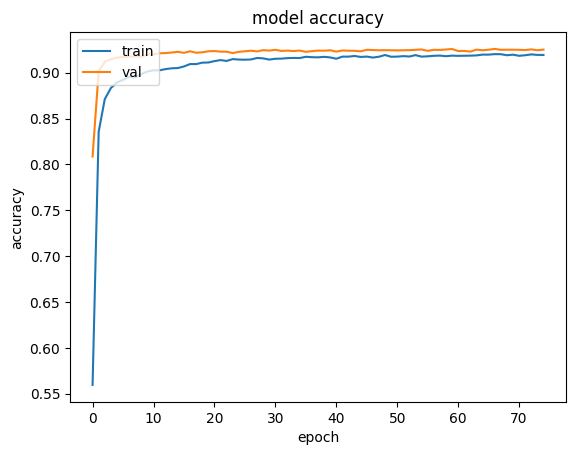

In [22]:
import keras
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

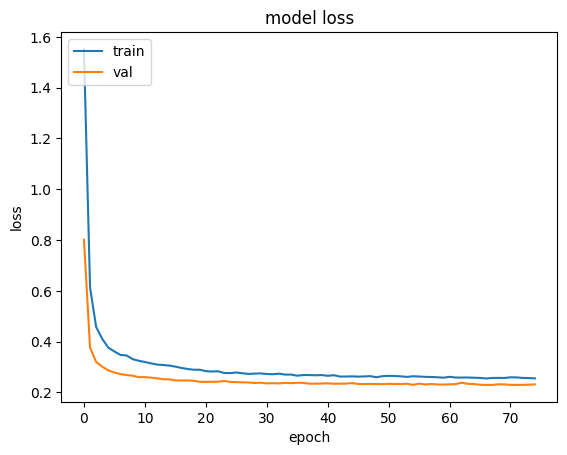

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

 1/64 [..............................] - ETA: 1s - loss: 0.3728 - accuracy: 0.8750

64/64 [==============================] - 0s 947us/step - loss: 0.2318 - accuracy: 0.9251


In [25]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 87ms/step
[7.4675978e-23 9.9627161e-01 1.2845931e-05 2.3025904e-12 1.7324087e-10
 5.0330318e-09 8.6270111e-09 3.5557179e-09 5.1005054e-09 9.4686534e-08
 6.0158847e-09 6.8088146e-11 6.8929268e-07 3.3931558e-03 8.4184478e-08
 3.2145903e-04]
1


In [26]:
accuracy = np.max(predict_result)
accuracy

0.9962716

# Confusion matrix

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [28]:
# Save as a model dedicated to inference
model.save(model_save_path)

In [29]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\MONSTER\AppData\Local\Temp\tmp26u4nz8r\assets


9644

# Inference test

In [39]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [40]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [41]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [42]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [43]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[7.4675675e-23 9.9627161e-01 1.2845918e-05 2.3025861e-12 1.7324088e-10
 5.0330224e-09 8.6269765e-09 3.5557111e-09 5.1004956e-09 9.4686534e-08
 6.0158731e-09 6.8088007e-11 6.8929273e-07 3.3931585e-03 8.4184471e-08
 3.2145905e-04]
1


In [44]:
import time

In [45]:
nofsample = 50

In [46]:
for i in range(0,nofsample):
    start_time = time.time()
    interpreter.set_tensor(input_details[0]["index"], np.array([X_test[i]]))
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]["index"])
    end_time = time.time()

inference_time = (end_time - start_time)/nofsample
print("Inference time:", inference_time, "seconds")

Inference time: 0.0 seconds


# Real Time Test

In [65]:
import csv
import copy
import argparse
import numpy as np

import cv2
import mediapipe as mp
import tensorflow as tf
from utils.helper_func import HelperFunc

In [67]:
model = tf.keras.models.load_model('model/hand_detection/hand_detection_model.keras')

In [68]:
min_detection_confidence = 0.7
min_tracking_confidence = 0.7

In [69]:
with open('model/hand_detection/hand_gesture_labels.csv',
              encoding='utf-8-sig') as f:
        hand_gesture_labels = csv.reader(f)
        hand_gesture_labels = [
            row[0] for row in hand_gesture_labels
        ]

In [70]:
hand_gesture_labels

['UP',
 'DOWN',
 'RIGHT',
 'LEFT',
 'FURTHER',
 'CLOSER',
 'LANDING',
 'TAKE_OFF',
 'PHOTO',
 'VIDEO',
 'VIDEO_STOP',
 'EMERGENCY',
 'FOLLOW',
 'PALM',
 'NO_CLASS']

In [ ]:
functions = HelperFunc()

device = 0
cap = cv2.VideoCapture(device)

use_pose = False

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

with mp_hands.Hands(
    max_num_hands=1,
    min_detection_confidence=min_detection_confidence,
    min_tracking_confidence=min_tracking_confidence) as hands:

    while cap.isOpened():

        ret,frame = cap.read()

        if not ret:
            print('Ignoring empty camera frame.')
            break

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        results = hands.process(rgb_frame)

        if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    hand_label = results.multi_handedness[0].classification[0].label
                    if hand_label == 'Left': 
                        # Landmark list calculation
                        landmark_list = functions.calc_landmark_list(rgb_frame, hand_landmarks,use_pose)
                        # Preprocessing landmark list
                        pre_processed_landmark_list = functions.pre_process_landmark(landmark_list)

                        # Inference test
                        predict_result = model.predict(np.array([pre_processed_landmark_list]),verbose=0)
                        hand_sign_id = np.argmax(np.squeeze(predict_result))
                        accuracy = np.max(predict_result)
                        accuracy = round(accuracy, 2)

                        # Bounding box calculation
                        brect = functions.calc_bounding_rect(rgb_frame, hand_landmarks)
                        # Drawing the bounding box on the frame
                        frame = functions.rect_corners(frame, brect)

                         # Draw the pose annotation on the image.
                        frame.flags.writeable = True
                
                        # Drawing the hand landmarks on the frame
                        mp_drawing.draw_landmarks(
                            frame, 
                            hand_landmarks, 
                            mp_hands.HAND_CONNECTIONS,
                            mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=3),
                            mp_drawing.DrawingSpec(color=(121,44,250), thickness=2))

                        info_text = hand_gesture_labels[hand_sign_id-1] +' '+str(accuracy)
                        frame = functions.text_with_background(
                        frame,
                        info_text,
                        (brect[0],brect[1]),
                        )                  

        # Display the frame
        cv2.imshow('Hand Detection', frame)

        # Break the loop if 'q' key is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()
